# Data Prep

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(".."))
#print("Estoy aquí:", os.getcwd())
#print("Archivos en esta carpeta:", os.listdir())


In [2]:
from src.preprocess.preprocessor import get_df
from src.config_training import TrainSettings

settings = TrainSettings()

TRAIN_START_DATE = settings.TRAIN_START_DATE
TRAIN_END_DATE = settings.TRAIN_END_DATE
TEST_START_DATE = settings.TEST_START_DATE
TEST_END_DATE = settings.TEST_END_DATE
INDICATORS = settings.INDICATORS

df_train = get_df(TRAIN_START_DATE, TRAIN_END_DATE, "../src/preprocess/tickers/ticker_lists.json")
df_test = get_df(TEST_START_DATE, TEST_END_DATE, "../src/preprocess/tickers/ticker_lists.json")
stock_dimension = len(df_train.tic.unique())


From: 2017-12-02 00:00:00
To: 2022-01-01
Shape of DataFrame:  (30810, 8)
Successfully added technical indicators
From: 2021-12-02 00:00:00
To: 2023-01-01
Shape of DataFrame:  (8160, 8)
Successfully added technical indicators


# Base RL

## Hyperparameter optimization

In [ ]:
from dev.hyperparameter_searching.base_RL_hs import hyperparams_opt_RL

hs_opt = hyperparams_opt_RL(
    df_train=df_train,
    df_test=df_test,
    indicators=INDICATORS,
    n_episodes_train=10,
    n_trials=80
)

hs_opt.run_opt()

## Training

In [3]:
# TRAINING with BEST HPs
from src.env_stocktrading.trading_env_RL import StockTradingEnv
from agent.base_RL_models import baseRLAgent

# state_space_noHRL = [balance, close prices_i, stock_shares_i, MACD_i, rsi30_i, cci30_i]
episode_len = df_train.dayorder.nunique()
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension 

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

tr_env = StockTradingEnv(
    df = df_train,
    stock_dim=stock_dimension,
    hmax= 100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space= state_space,
    action_space= stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=False,
    print_verbosity=2
)

agent = baseRLAgent(env=tr_env)



best_hiperparams= {'gamma': 0.9982572049354244, 
                   'max_grad_norm': 1.004287538508153, 
                   'n_steps': 256, 
                   'learning_rate': 0.0002750235733375285, 
                   'ent_coef': 6.465134048701665e-05}



model = agent.get_model("a2c",
                        learning_rate = best_hiperparams['learning_rate'],
                        gamma = best_hiperparams['gamma'],
                        max_grad_norm = best_hiperparams['max_grad_norm'],
                        n_steps = best_hiperparams['n_steps'],
                        ent_coef = best_hiperparams['ent_coef'],
                        verbose=1)

n_episodes = 10
trained_model = agent.train_model(
    model,
    tb_log_name="a2c_best_hp",
    total_timesteps= n_episodes*episode_len
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/a2c_best_hp_5
day: 1007, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1288967.09
total_reward: 288967.09
total_cost: 176874.54
total_trades: 27107
Sharpe: 0.405
day: 1007, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1628991.92
total_reward: 628991.92
total_cost: 174776.92
total_trades: 26744
Sharpe: 0.647
day: 1007, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 1890420.11
total_reward: 890420.11
total_cost: 180263.88
total_trades: 26904
Sharpe: 0.831
day: 1007, episode: 8
begin_total_asset: 1000000.00
end_total_asset: 1595942.90
total_reward: 595942.90
total_cost: 171477.74
total_trades: 26397
Sharpe: 0.631
day: 1007, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1739536.84
total_reward: 739536.84
total_cost: 171975.08
total_trades: 26480
Sharpe: 0.744


In [ ]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline

ea = event_accumulator.EventAccumulator("logs/a2c_best_hp_6")  # cambia tu ruta
ea.Reload()

loss_key = "train/value_loss"
data = ea.Scalars(loss_key)

steps = [x.step for x in data]
values = [x.value for x in data]

plt.plot(steps, values)
plt.title("Value Loss")
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.show()

In [ ]:
loss_key = "train/policy_loss"
data = ea.Scalars(loss_key)

plt.plot([x.step for x in data], [x.value for x in data])
plt.title("Policy Loss")
plt.show()

In [ ]:
loss_key = "train/entropy_loss"
#loss_key = "rollout/ep_rew_mean"
data = ea.Scalars(loss_key)

plt.plot([x.step for x in data], [x.value for x in data])
plt.title(loss_key)
plt.show()

In [ ]:
ea.Scalars("rollout/ep_rew_mean")

In [ ]:
# TESTING
test_env = StockTradingEnv(
    df = df_test,
    stock_dim=stock_dimension,
    hmax= 100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space= state_space,
    action_space= stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=True,
    print_verbosity=1
)

df_account_value_a2c, df_actions_a2c, last_state = baseRLAgent.predict_RL(
    model=trained_model, 
    environment = test_env)

df = pd.DataFrame()


Starting prediction...
day: 250, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 986102.11
total_reward: -13897.89
total_cost: 1027.29
total_trades: 2748
Sharpe: 0.039
hit end!


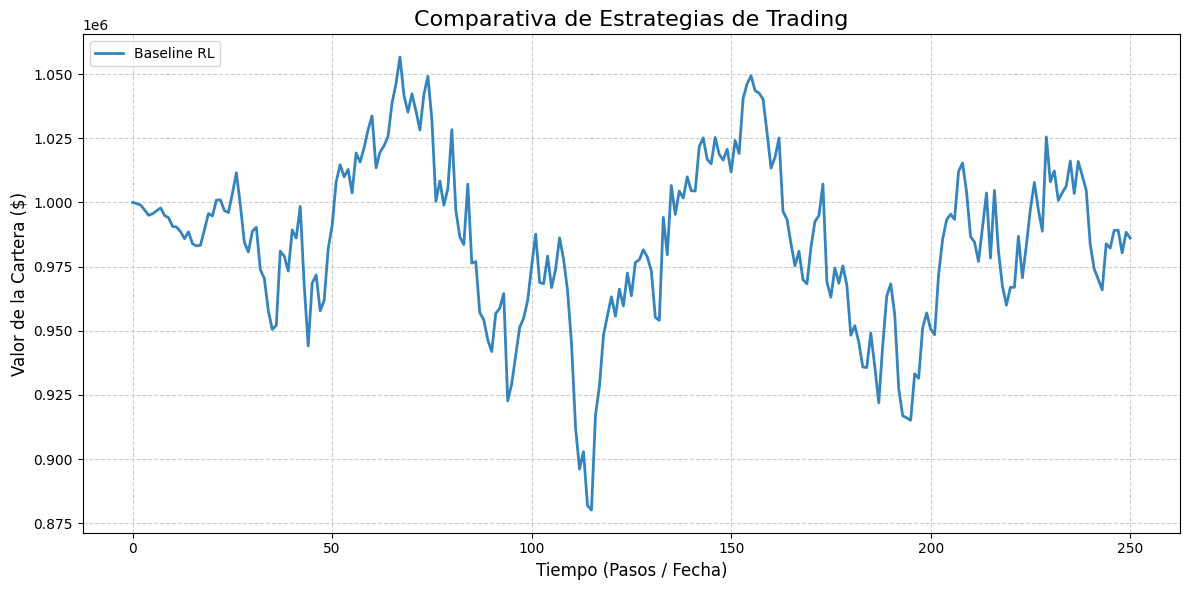

<Figure size 640x480 with 0 Axes>

In [7]:
from eval.evaluate_functions import plot_portfolio_evolution, calculate_portfolio_metrics
%matplotlib inline
df_list = [df_account_value_a2c]
label_list = ["Baseline RL"]
plot_portfolio_evolution(df_list, label_list)


In [8]:
calculate_portfolio_metrics(df_account_value_a2c, last_state[31:61])

,Final Balance ($),Cumulative Return (%),Sharpe Ratio,Diversification (%),Active Assets
0,986102.11,-1.39,0.0394,23.33,7/30


In [ ]:
df_account_value_a2c

In [ ]:
last_state[0][31:61]

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', None,
                       'display.max_colwidth', None):
    display(df_actions_a2c)




# HRL

In [ ]:
from src.env_stocktrading.trading_env_HRL import StockTradingEnvHRL

# state_space_manager = [close prices_i, MACD_i, rsi30_i, cci30_i] Quizas quitar algún indicador

# state_space_worker = [balance, close_prices_i, stock_shares_i, manager_actions_i]                 # QUizás añadir agún indicador de riesgo a estudiar y hacer pruebas



# state_space_noHRL = [balance, close prices_i, stock_shares_i, MACD_i, rsi30_i, cci30_i]


# action_space_manager = {-1, 0, 1} * 30
# action_space_manager = {0,1} * 30 (para calcular cuántas, multiplicar por hmax)

episode_len = processed.dayorder.nunique()
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension

state_space_manager = (len(INDICATORS) + 1)*stock_dimension
state_space_worker = (1 + 3*stock_dimension)



buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension


tr_env = StockTradingEnvHRL(
    df = processed,
    stock_dim=stock_dimension,
    hmax= 100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space= state_space,
    action_space= stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=True,
    print_verbosity=1
)

# Pendiente

- LR está en 0.0003: Probar a bajar a 5e-5 o 1e-5
- Incluir train -> Test etc